# 04. Model Tuning
# Teh-Moms Application Data

This notebook focuses on tuning and improving the best models from benchmark results

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import json

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.inspection import permutation_importance

# For dimensionality reduction
from sklearn.decomposition import PCA

# Import model types based on benchmarking results
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# For visualizations
plt.style.use('seaborn-v0_8-whitegrid')  # Set a clean, readable style for plots
sns.set_palette("viridis")  # Use a perceptually uniform and colorblind-friendly palette
plt.rcParams['figure.figsize'] = (14, 8)  # Set default figure size for readability

In [3]:
# For reproducibility
np.random.seed(42)  # Set seed to ensure results are reproducible

# 1. Load Data and Prior Results

In [4]:
print("1. Loading Data and Benchmark Results")
print("-----------------------------------")

1. Loading Data and Benchmark Results
-----------------------------------


In [5]:
# Load the preprocessed data
df = pd.read_csv('tech_moms_preprocessed.csv')

In [6]:
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print(f"Acceptance rate: {df['accepted'].mean():.2%}")

# ANALYSIS: The acceptance rate provides context about class imbalance in our dataset
# A rate of around 33% indicates moderate class imbalance that should be addressed

Loaded dataset with 1732 rows and 55 columns
Acceptance rate: 32.74%


In [7]:
# Load the best model from benchmarking
try:
    best_model = joblib.load('best_model_naive_bayes.pkl')
    print("Successfully loaded Naive Bayes model from benchmarking notebook")
except:
    print("Model file not found. Initializing a new Naive Bayes model.")
    best_model = GaussianNB()  # Default to GaussianNB if file not found
    # ANALYSIS: GaussianNB assumes features follow Gaussian distribution
    # This assumption may not hold for binary/categorical features

Successfully loaded Naive Bayes model from benchmarking notebook


In [8]:
# Load feature columns
try:
    feature_columns = joblib.load('model_feature_columns.pkl')
    print(f"Loaded {len(feature_columns)} feature columns")
except:
    print("Feature columns file not found. Will extract features from dataframe.")
    # Extract features similar to the benchmark notebook
    exclude_columns = ['contact_id', 'cohort', 'applicant_status',
                   'create_date', 'year', 'month', 'day', 'weekday',
                   'children', 'computer_availability', 'employment_status',
                   'salary_range', 'relationship_and_marital_status',
                   'household_income', 'education_level', 'lgbtqi_identity',
                   'veteran_status', 'race_ethnicity']
    feature_columns = [col for col in df.columns if col not in exclude_columns and col != 'accepted']

Loaded 37 feature columns


In [9]:
# Extract features and target
X = df[feature_columns]  # Feature matrix
y = df['accepted']       # Target variable

In [10]:
# Split the data - using the same random_state as benchmark for consistency
# ANALYSIS: Using stratify=y ensures class distribution is preserved in both train and test sets
# This is critical for imbalanced data to ensure representative evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Class distribution in training data: {np.bincount(y_train)}")
print(f"Class distribution in test data: {np.bincount(y_test)}")
# ANALYSIS: Verifying the class balance in both splits confirms stratification worked

Training data shape: (1385, 37), Test data shape: (347, 37)
Class distribution in training data: [932 453]
Class distribution in test data: [233 114]


# 2. Analyze Naive Bayes Performance in Detail

In [12]:
print("\n2. Detailed Analysis of Naive Bayes Performance")
print("--------------------------------------------")


2. Detailed Analysis of Naive Bayes Performance
--------------------------------------------


In [13]:
# Retrain the model for consistency
# ANALYSIS: We're retraining the model to ensure all metrics are calculated on the same trained model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of positive class

In [14]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

In [15]:
# Print performance metrics
print("\nNaive Bayes Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
# ANALYSIS: These metrics show that Naive Bayes achieves moderate performance
# Higher recall than precision suggests it tends to predict the positive class more liberally


Naive Bayes Performance:
Accuracy: 0.4784
Precision: 0.3665
Recall: 0.8070
F1 Score: 0.5041
ROC AUC: 0.5952


<Figure size 800x600 with 0 Axes>

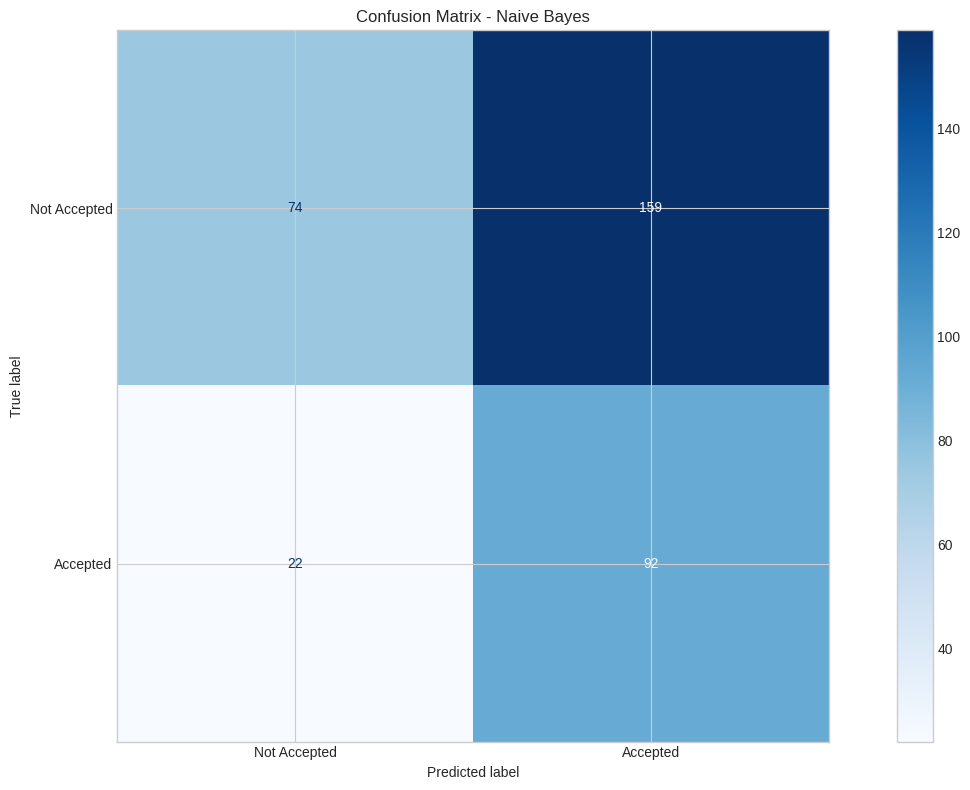

In [16]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Accepted', 'Accepted'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Naive Bayes')
plt.tight_layout()
plt.show()
# ANALYSIS: The confusion matrix shows the distribution of prediction errors
# True Negatives (top-left), False Positives (top-right)
# False Negatives (bottom-left), True Positives (bottom-right)
# Higher number of False Positives than False Negatives confirms our observation
# about higher recall than precision

Note: The confusion matrix shows the distribution of prediction errors

True Negatives (top-left), False Positives (top-right)

False Negatives (bottom-left), True Positives (bottom-right)

Higher number of False Positives than False Negatives confirms our observation about higher recall than precision

<Figure size 800x600 with 0 Axes>

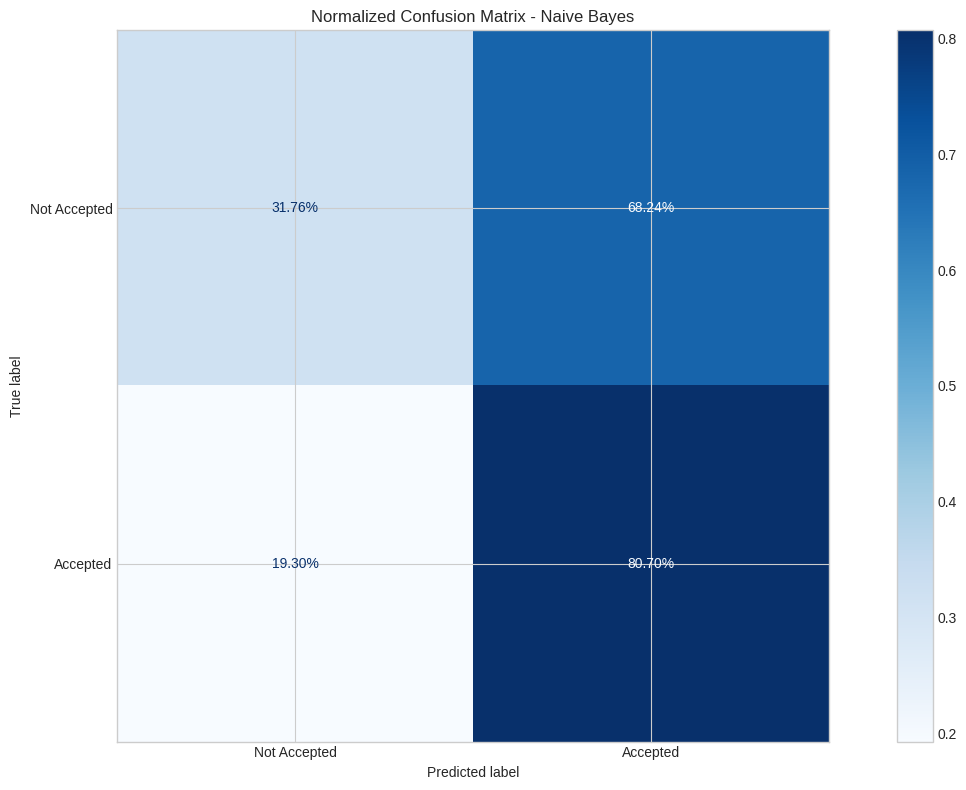

In [17]:
# Calculate normalized confusion matrix (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (true label)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=['Not Accepted', 'Accepted'])
disp.plot(cmap='Blues', values_format='.2%')
plt.title('Normalized Confusion Matrix - Naive Bayes')
plt.tight_layout()
plt.show()
# ANALYSIS: Normalized matrix shows percentages by true class
# We can see what percentage of each class is correctly/incorrectly classified
# This helps adjust for class imbalance in the visual representation

In [18]:
# Detailed analysis by class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# ANALYSIS: The classification report breaks down performance by class
# 'Support' shows the number of samples in each class, confirming imbalance
# 'macro avg' weighs each class equally regardless of sample size
# 'weighted avg' weighs classes by their frequency in the dataset


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.32      0.45       233
           1       0.37      0.81      0.50       114

    accuracy                           0.48       347
   macro avg       0.57      0.56      0.48       347
weighted avg       0.64      0.48      0.47       347



# 3. Permutation Feature Importance for Naive Bayes

In [19]:
print("\n3. Feature Importance Analysis")
print("---------------------------")


3. Feature Importance Analysis
---------------------------


## 3.1 Permutation Importance

In [20]:
print("\n3.1 Permutation Feature Importance")
print("------------------------------")
# ANALYSIS: Naive Bayes doesn't have built-in feature importance like tree-based models
# Permutation importance is algorithm-agnostic and works by measuring how much
# model performance drops when a feature is randomly shuffled


3.1 Permutation Feature Importance
------------------------------


In [21]:
# Calculate permutation importance
# ANALYSIS: This randomly shuffles each feature column and measures the drop in performance
# Features that cause larger drops when shuffled are more important to the model
perm_importance = permutation_importance(best_model, X_test, y_test,
                                        n_repeats=10, random_state=42)
# n_repeats=10 means we shuffle each feature 10 times and take the average impact

In [22]:
# Create DataFrame of feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': perm_importance.importances_mean,  # Average importance across repetitions
    'Std': perm_importance.importances_std  # Standard deviation of importance (shows stability)
})

In [23]:
# Sort by importance (descending)
feature_importance = feature_importance.sort_values('Importance', ascending=False)

In [24]:
# Display top 20 most important features
print("\nTop 20 most important features (Permutation Importance):")
print(feature_importance.head(20))
# ANALYSIS: These features have the largest impact on model predictions
# Knowing these helps us understand what drives acceptance decisions
# Can inform both applicants and program administrators


Top 20 most important features (Permutation Importance):
                                              Feature  Importance       Std
0                                        has_computer    0.005476  0.002017
13                     education_category_High School    0.004611  0.003458
27  ethnicity_simplified_American Indian or Alaska...    0.003458  0.001153
3         computer_availability_I do not own a laptop    0.002882  0.000000
4                  computer_availability_Laptop (Mac)    0.002305  0.001729
24                     children_category_2-3 Children    0.002017  0.001321
7                     employment_simplified_Full-time    0.001729  0.002939
32      ethnicity_simplified_Hispanic or Latina,White    0.001729  0.002939
12                        education_category_Bachelor    0.001441  0.002953
8                  employment_simplified_Not Employed    0.001441  0.004126
1                                             quarter    0.001153  0.001912
11                 education_c

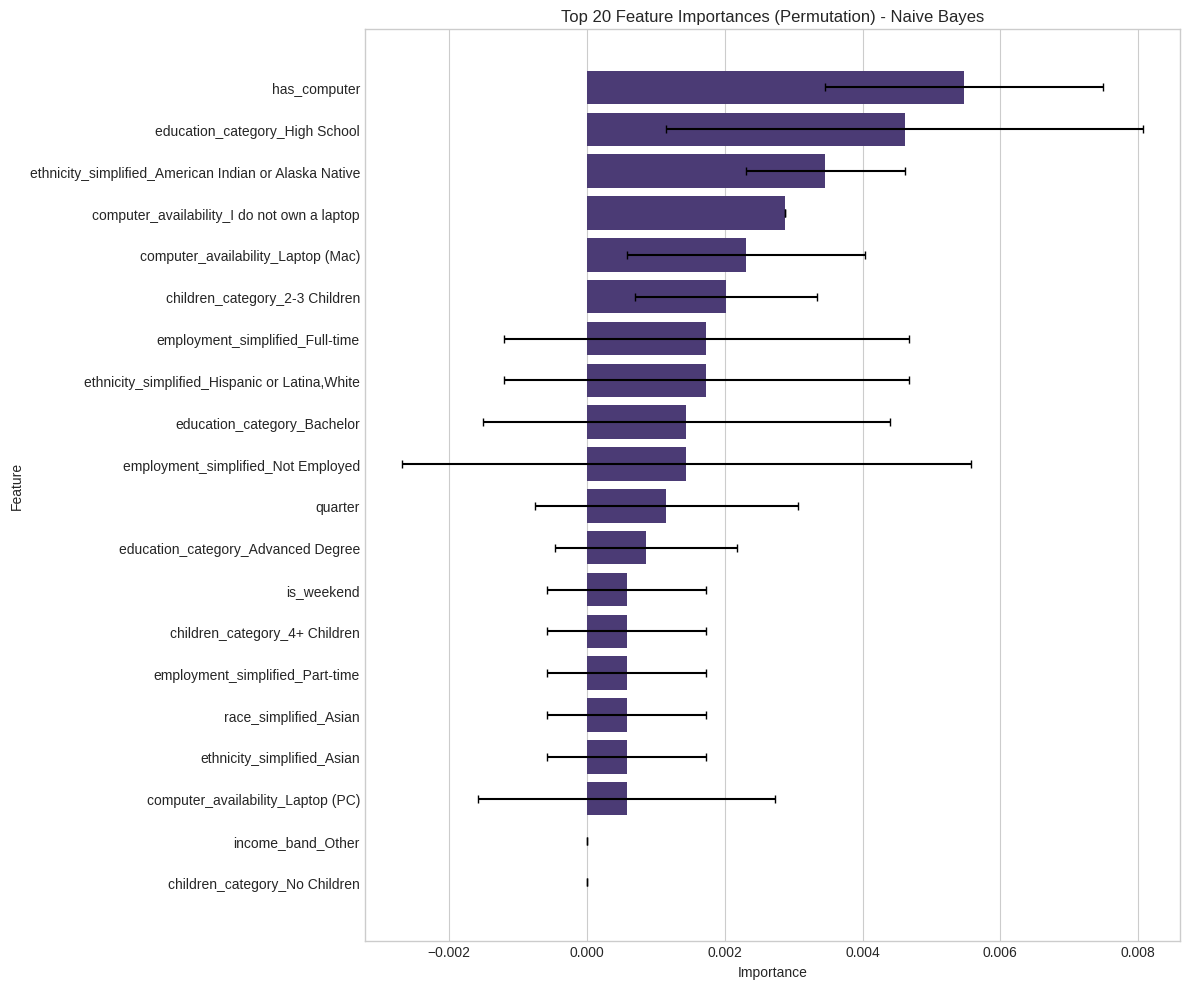

In [25]:
# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance.head(20)
)
plt.errorbar(
    feature_importance['Importance'].head(20),
    range(20),
    xerr=feature_importance['Std'].head(20),
    fmt='none',
    ecolor='black',
    capsize=3
)
plt.title('Top 20 Feature Importances (Permutation) - Naive Bayes')
plt.tight_layout()
plt.show()
# ANALYSIS: Error bars show variation in importance across repetitions
# Wide error bars indicate the feature's importance is less consistent
# Program administrators should focus on features with high importance and narrow error bars

## 3.2 PCA for Feature Correlation Analysis

In [26]:
print("\n3.2 PCA Feature Analysis")
print("--------------------")
# ANALYSIS: PCA helps identify patterns of correlation and redundancy in features
# It can also be used to reduce dimensionality and potentially improve model performance


3.2 PCA Feature Analysis
--------------------


In [27]:
# Standardize features for PCA
# ANALYSIS: PCA is sensitive to scale, so standardization is necessary
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Apply PCA
# ANALYSIS: We'll retain enough components to explain 95% of variance
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [29]:
# Print PCA results
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


In [30]:
print(f"\nPCA retained {n_components} components out of {X_train.shape[1]} original features")
print(f"These components explain {cumulative_variance[-1]*100:.2f}% of the total variance")


PCA retained 22 components out of 37 original features
These components explain 95.36% of the total variance


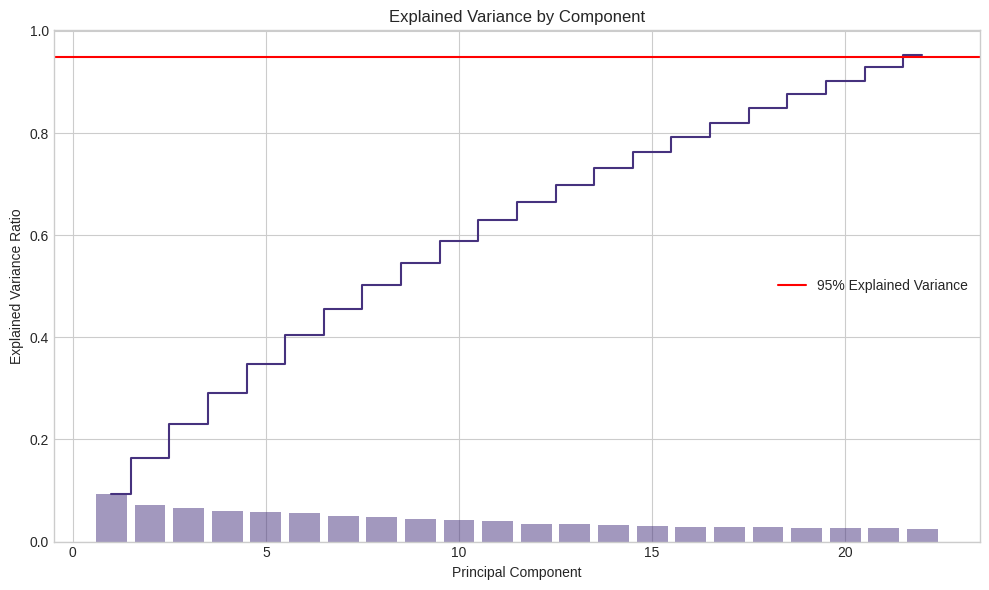

In [31]:
# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()
# ANALYSIS: This plot shows how much variance each component explains
# A steep curve indicates that a small number of components capture most of the information
# A flat curve indicates high dimensionality with distributed information

In [32]:
# Evaluate Naive Bayes on PCA-reduced features
# ANALYSIS: PCA often improves Naive Bayes performance by reducing feature correlations
# Naive Bayes assumes feature independence, which is often violated in practice
nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train)
y_pred_pca = nb_pca.predict(X_test_pca)
y_proba_pca = nb_pca.predict_proba(X_test_pca)[:, 1]

In [33]:
# Calculate performance metrics with PCA
accuracy_pca = accuracy_score(y_test, y_pred_pca)
precision_pca = precision_score(y_test, y_pred_pca)
recall_pca = recall_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)
roc_auc_pca = roc_auc_score(y_test, y_proba_pca)

In [34]:
print("\nNaive Bayes Performance with PCA:")
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"Precision: {precision_pca:.4f}")
print(f"Recall: {recall_pca:.4f}")
print(f"F1 Score: {f1_pca:.4f}")
print(f"ROC AUC: {roc_auc_pca:.4f}")
# ANALYSIS: Compare these metrics with the original Naive Bayes performance
# Improvements would suggest that feature correlations were hurting performance


Naive Bayes Performance with PCA:
Accuracy: 0.6196
Precision: 0.4318
Recall: 0.5000
F1 Score: 0.4634
ROC AUC: 0.6010


In [35]:
# Compare original and PCA performance
print("\nComparison with Original Model:")
comparison_pca = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Original': [accuracy, precision, recall, f1, roc_auc],
    'With PCA': [accuracy_pca, precision_pca, recall_pca, f1_pca, roc_auc_pca],
    'Difference': [accuracy_pca - accuracy, precision_pca - precision,
                   recall_pca - recall, f1_pca - f1, roc_auc_pca - roc_auc]
})
print(comparison_pca)
# ANALYSIS: Positive differences indicate PCA improved performance
# Negative differences indicate PCA reduced performance
# Mixed results are common and suggest a more nuanced approach is needed


Comparison with Original Model:
      Metric  Original  With PCA  Difference
0   Accuracy  0.478386  0.619597    0.141210
1  Precision  0.366534  0.431818    0.065284
2     Recall  0.807018  0.500000   -0.307018
3   F1 Score  0.504110  0.463415   -0.040695
4    ROC AUC  0.595249  0.601009    0.005760


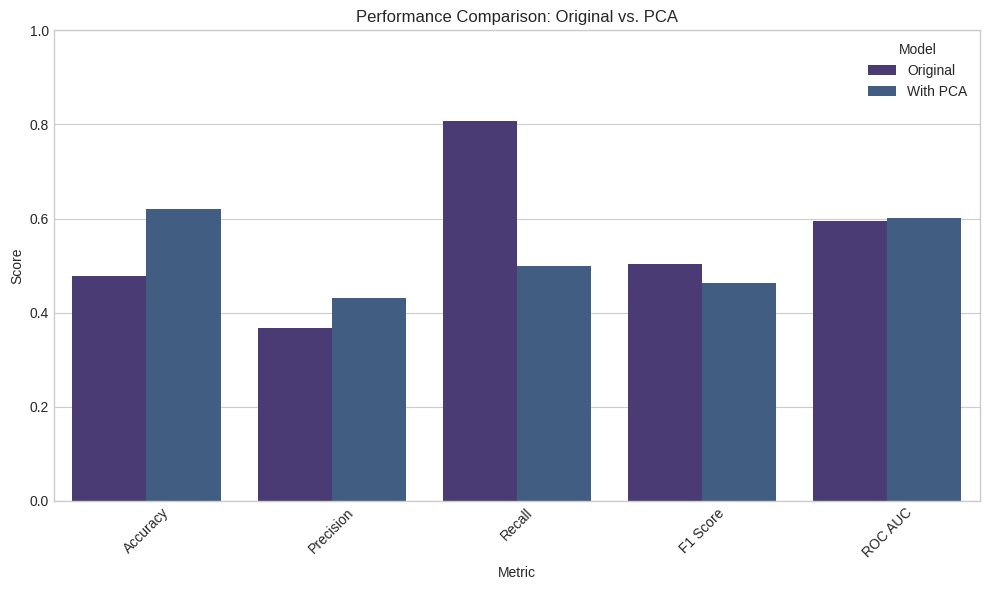

In [36]:
# Visualize performance comparison
plt.figure(figsize=(10, 6))
comparison_melted = pd.melt(comparison_pca, id_vars='Metric',
                           value_vars=['Original', 'With PCA'],
                           var_name='Model', value_name='Score')
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_melted)
plt.title('Performance Comparison: Original vs. PCA')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ANALYSIS: This visualization makes it easy to compare performance metrics
# across original and PCA-based models

# 4. Cross-Validation for More Robust Evaluation

In [37]:
print("\n4. Cross-Validation Evaluation")
print("----------------------------")
# ANALYSIS: Cross-validation provides a more reliable estimate of model performance
# by training and testing on multiple different splits of the data


4. Cross-Validation Evaluation
----------------------------


In [38]:
# Define cross-validation strategy
# ANALYSIS: StratifiedKFold maintains class proportions in each fold
# This is crucial for imbalanced data like ours
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4.1 Cross-validation on original features

In [39]:
print("\n4.1 Cross-validation on original features")
# ANALYSIS: We're using F1 score as our metric because it balances precision and recall
# This is appropriate for imbalanced classification tasks
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='f1')


4.1 Cross-validation on original features


In [40]:
print("\nCross-Validation Results (F1 Score) - Original Features:")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Individual Fold Scores: {cv_scores}")
# ANALYSIS: Standard deviation indicates stability of model performance
# Lower standard deviation means more consistent performance across different data splits


Cross-Validation Results (F1 Score) - Original Features:
Mean F1 Score: 0.4991
Standard Deviation: 0.0159
Individual Fold Scores: [0.48753463 0.51461988 0.47701149 0.49748744 0.51891892]


## 4.2 Cross-validation on PCA features

In [41]:
print("\n4.2 Cross-validation on PCA features")
# ANALYSIS: This helps evaluate if PCA consistently improves performance
# across different data splits
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
cv_scores_pca = cross_val_score(GaussianNB(), X_pca, y, cv=cv, scoring='f1')


4.2 Cross-validation on PCA features


In [42]:
print("\nCross-Validation Results (F1 Score) - PCA Features:")
print(f"Mean F1 Score: {cv_scores_pca.mean():.4f}")
print(f"Standard Deviation: {cv_scores_pca.std():.4f}")
print(f"Individual Fold Scores: {cv_scores_pca}")
# ANALYSIS: Comparing these results with the original cross-validation
# gives a more robust assessment of PCA's impact


Cross-Validation Results (F1 Score) - PCA Features:
Mean F1 Score: 0.4239
Standard Deviation: 0.0559
Individual Fold Scores: [0.47213115 0.31683168 0.42181818 0.45360825 0.45487365]


In [43]:
# Compare cross-validation results
print("\nComparison of Cross-Validation Results:")
print(f"Original Features - Mean F1: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
print(f"PCA Features - Mean F1: {cv_scores_pca.mean():.4f}, Std: {cv_scores_pca.std():.4f}")
print(f"Difference in Mean F1: {cv_scores_pca.mean() - cv_scores.mean():.4f}")
# ANALYSIS: This comparison shows if PCA consistently improves performance
# across different data splits


Comparison of Cross-Validation Results:
Original Features - Mean F1: 0.4991, Std: 0.0159
PCA Features - Mean F1: 0.4239, Std: 0.0559
Difference in Mean F1: -0.0753


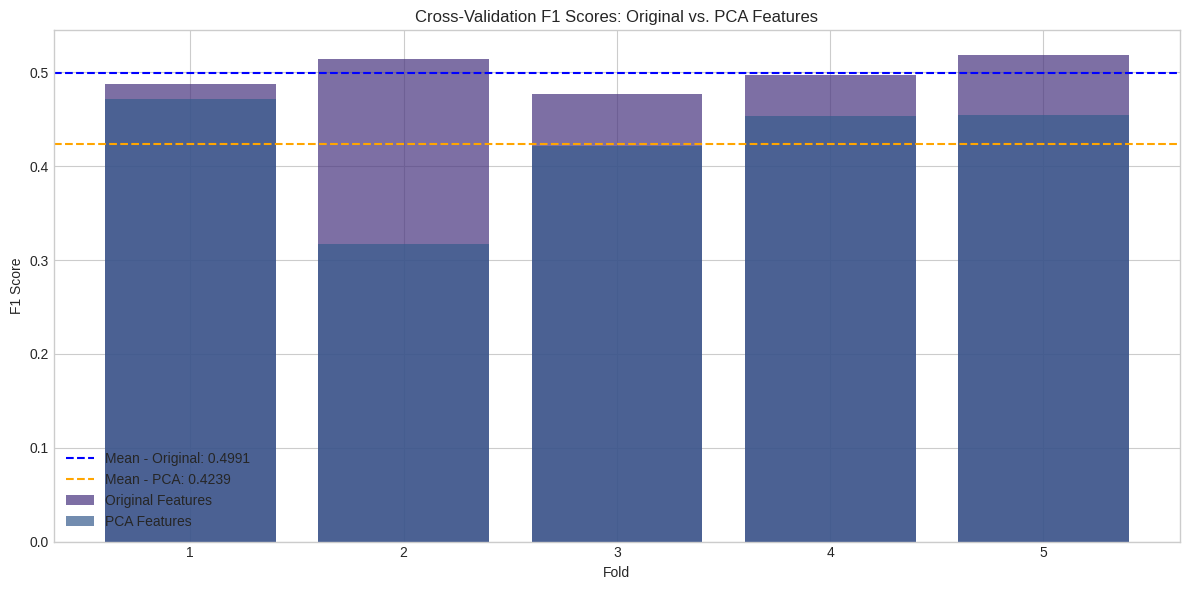

In [44]:
# Visualize cross-validation comparison
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, label='Original Features')
plt.bar(range(1, len(cv_scores_pca) + 1), cv_scores_pca, alpha=0.7, label='PCA Features')
plt.axhline(y=cv_scores.mean(), color='blue', linestyle='--', label=f'Mean - Original: {cv_scores.mean():.4f}')
plt.axhline(y=cv_scores_pca.mean(), color='orange', linestyle='--', label=f'Mean - PCA: {cv_scores_pca.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Cross-Validation F1 Scores: Original vs. PCA Features')
plt.legend()
plt.tight_layout()
plt.show()
# ANALYSIS: This visualization shows performance variation across CV folds
# for both original and PCA-based features

# 5. Learning Curves to Assess Overfitting/Underfitting

In [45]:
print("\n5. Learning Curves Analysis")
print("------------------------")
# ANALYSIS: Learning curves help diagnose overfitting or underfitting by showing
# how model performance changes with increasing training data size


5. Learning Curves Analysis
------------------------


## 5.1 Learning curves for original features

In [46]:
print("\n5.1 Learning curves for original features")
# ANALYSIS: We train the model on progressively larger subsets of the training data
# and evaluate performance on both training and validation sets
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=cv, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 different training set sizes from 10% to 100%
    random_state=42
)


5.1 Learning curves for original features


In [47]:
# Calculate means and standard deviations across CV folds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

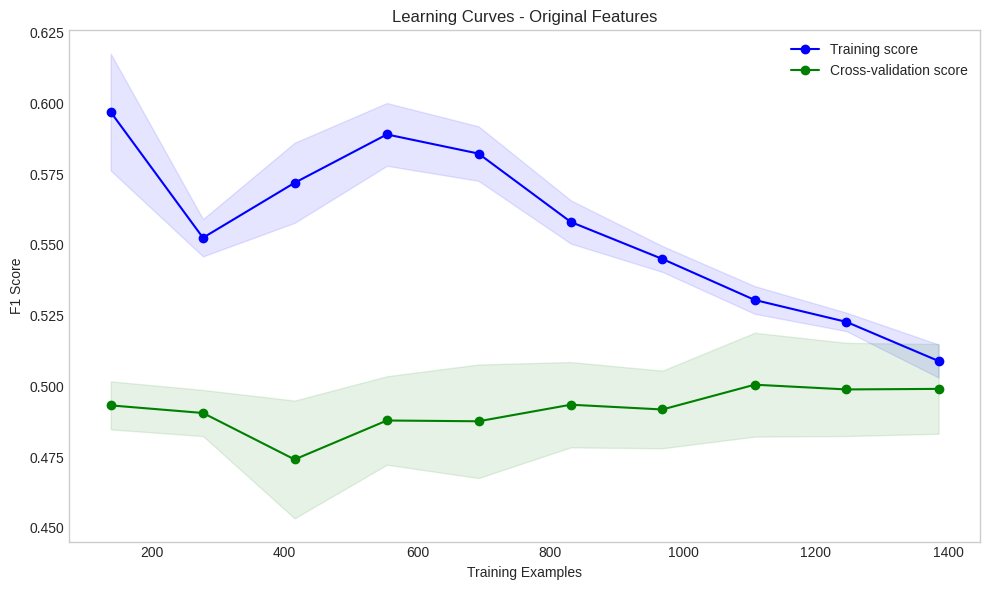

In [48]:
# Plot learning curves for original features
plt.figure(figsize=(10, 6))
plt.grid()
# Fill regions representing standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
# Plot mean curves
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.title('Learning Curves - Original Features')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# ANALYSIS: The gap between training and validation curves indicates overfitting
# If both curves are low and close together, the model may be underfitting
# If both curves are high and close, the model has good fit

## 5.2 Learning curves for PCA features

In [49]:
print("\n5.2 Learning curves for PCA features")
# ANALYSIS: Comparing learning curves between original and PCA features
# helps understand if PCA reduces overfitting
train_sizes_pca, train_scores_pca, test_scores_pca = learning_curve(
    GaussianNB(), X_pca, y, cv=cv, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)


5.2 Learning curves for PCA features


In [50]:
# Calculate means and standard deviations
train_mean_pca = np.mean(train_scores_pca, axis=1)
train_std_pca = np.std(train_scores_pca, axis=1)
test_mean_pca = np.mean(test_scores_pca, axis=1)
test_std_pca = np.std(test_scores_pca, axis=1)

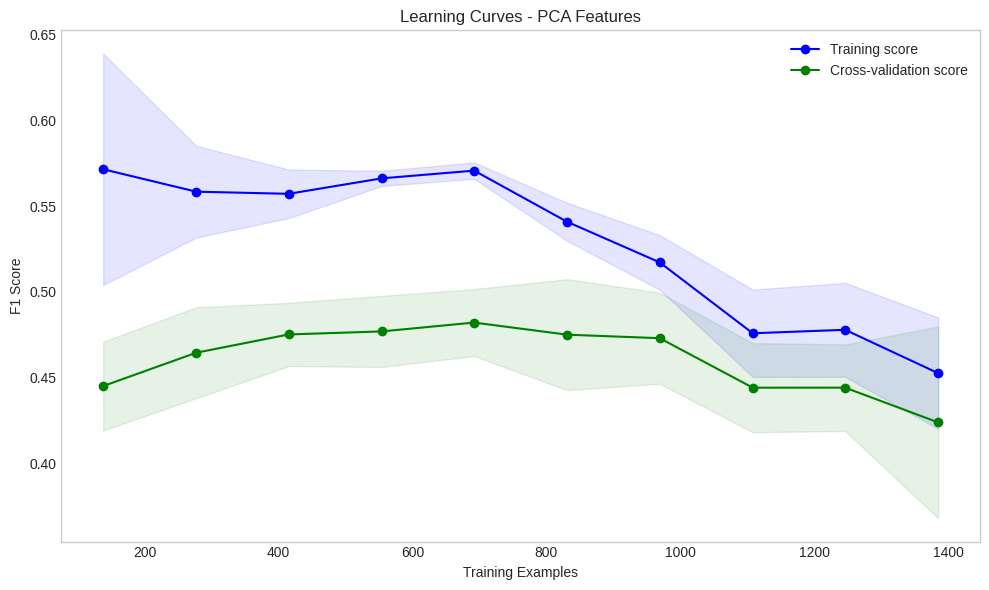

In [51]:
# Plot learning curves for PCA features
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes_pca, train_mean_pca - train_std_pca,
                train_mean_pca + train_std_pca, alpha=0.1, color='blue')
plt.fill_between(train_sizes_pca, test_mean_pca - test_std_pca,
                test_mean_pca + test_std_pca, alpha=0.1, color='green')
plt.plot(train_sizes_pca, train_mean_pca, 'o-', color='blue', label='Training score')
plt.plot(train_sizes_pca, test_mean_pca, 'o-', color='green', label='Cross-validation score')
plt.title('Learning Curves - PCA Features')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# ANALYSIS: Compare this with the learning curve for original features
# Reduced gap between curves would suggest less overfitting with PCA

# 6. Calibration Analysis

In [52]:
print("\n6. Probability Calibration Analysis")
print("--------------------------------")
# ANALYSIS: Calibration measures how well the predicted probabilities match observed frequencies
# Well-calibrated models produce reliable probability estimates, which are important for
# decision-making and threshold optimization


6. Probability Calibration Analysis
--------------------------------


## 6.1 Calibration curve for original model

In [53]:
print("\n6.1 Calibration curve for original model")
# ANALYSIS: This groups predictions into bins and compares predicted probabilities
# with the actual proportion of positive samples in each bin
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)


6.1 Calibration curve for original model


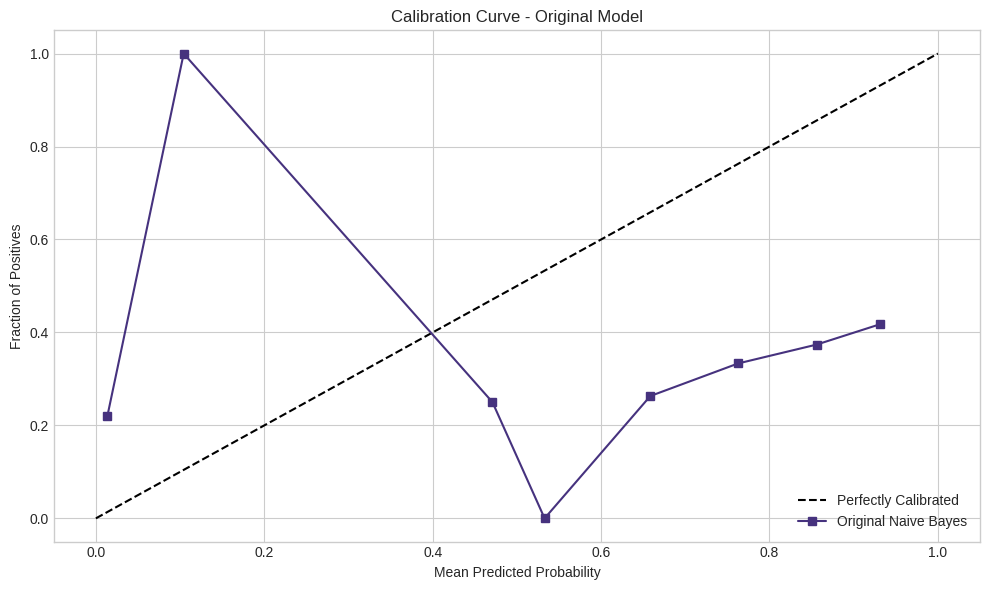

In [54]:
# Plot calibration curve for original model
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')  # Diagonal represents perfect calibration
plt.plot(prob_pred, prob_true, 's-', label='Original Naive Bayes')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Original Model')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
# ANALYSIS: Points above the diagonal indicate underestimation of probabilities
# Points below indicate overestimation
# Naive Bayes often produces poorly calibrated probabilities due to its strong independence assumption

## 6.2 Calibration curve for PCA model

In [55]:
print("\n6.2 Calibration curve for PCA model")
# ANALYSIS: Compare calibration between original and PCA models
# to see if PCA improves probability estimates
prob_true_pca, prob_pred_pca = calibration_curve(y_test, y_proba_pca, n_bins=10)


6.2 Calibration curve for PCA model


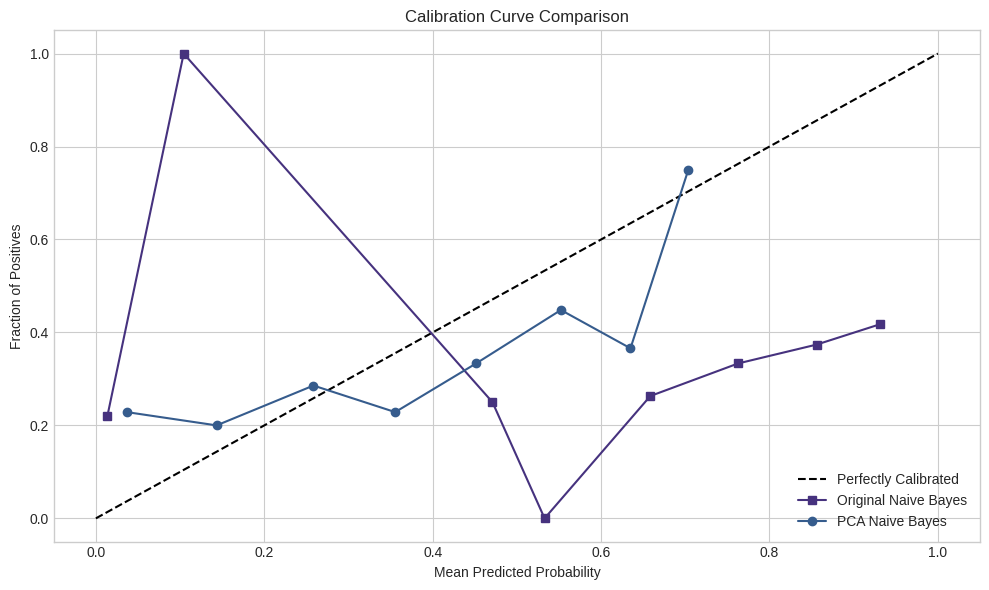

In [56]:
# Plot calibration curves comparing both models
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Original Naive Bayes')
plt.plot(prob_pred_pca, prob_true_pca, 'o-', label='PCA Naive Bayes')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve Comparison')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
# ANALYSIS: This comparison shows if PCA improves probability calibration
# Better calibration would lead to more reliable probability estimates

In [57]:
# Calculate calibration errors
calib_error = np.mean(np.abs(prob_pred - prob_true))
calib_error_pca = np.mean(np.abs(prob_pred_pca - prob_true_pca))

In [58]:
print("\nCalibration Analysis:")
print(f"Mean Absolute Calibration Error - Original: {calib_error:.4f}")
print(f"Mean Absolute Calibration Error - PCA: {calib_error_pca:.4f}")
print(f"Improvement with PCA: {(calib_error - calib_error_pca) * 100:.2f}%")
# ANALYSIS: Lower calibration error means more reliable probability estimates
# This affects decision thresholds and confidence in predictions


Calibration Analysis:
Mean Absolute Calibration Error - Original: 0.4595
Mean Absolute Calibration Error - PCA: 0.1175
Improvement with PCA: 34.20%


# 7. Handling Class Imbalance

In [59]:
print("\n7. Class Imbalance Techniques")
print("---------------------------")
# ANALYSIS: Class imbalance can bias models toward the majority class
# We'll test several approaches to address this issue


7. Class Imbalance Techniques
---------------------------


## 7.1 Alternative Naive Bayes Variants

In [60]:
print("\n7.1 Alternative Naive Bayes Variants")
# ANALYSIS: Different NB variants have different assumptions and may handle imbalance differently
# Complement NB was specifically designed with imbalanced data in mind


7.1 Alternative Naive Bayes Variants


In [61]:
# Try different Naive Bayes variants
nb_variants = {
    'Gaussian NB': GaussianNB(),  # Assumes features follow Gaussian distribution
    'Bernoulli NB': BernoulliNB(),  # Designed for binary/boolean features
    'Multinomial NB': MultinomialNB(),  # Designed for discrete count features (e.g., word counts)
    'Complement NB': ComplementNB()  # Designed for imbalanced text classification
}

In [62]:
# Compare different NB variants on original features
print("\nNaive Bayes Variants on Original Features:")
variant_results = {}
for name, model in nb_variants.items():
    try:
        # Fit and evaluate
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        variant_results[name] = f1
        print(f"{name} - F1 Score: {f1:.4f}")
    except Exception as e:
        print(f"{name} - Error: {str(e)}")
        # ANALYSIS: Some variants might fail if data doesn't match their assumptions
        # For example, MultinomialNB expects non-negative features


Naive Bayes Variants on Original Features:
Gaussian NB - F1 Score: 0.5041
Bernoulli NB - F1 Score: 0.2840
Multinomial NB - F1 Score: 0.0923
Complement NB - F1 Score: 0.5202


In [63]:
# Compare different NB variants on PCA features
print("\nNaive Bayes Variants on PCA Features:")
variant_results_pca = {}
for name, model in nb_variants.items():
    try:
        # Fit and evaluate
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        f1 = f1_score(y_test, y_pred)
        variant_results_pca[name] = f1
        print(f"{name} with PCA - F1 Score: {f1:.4f}")
    except Exception as e:
        print(f"{name} with PCA - Error: {str(e)}")
        # ANALYSIS: Some variants might work better with PCA
        # Since PCA transforms features to be more Gaussian-like


Naive Bayes Variants on PCA Features:
Gaussian NB with PCA - F1 Score: 0.4634
Bernoulli NB with PCA - F1 Score: 0.1460
Multinomial NB with PCA - Error: Negative values in data passed to MultinomialNB (input X).
Complement NB with PCA - Error: Negative values in data passed to ComplementNB (input X).


In [64]:
# Find best variant for original and PCA features
best_variant = max(variant_results.items(), key=lambda x: x[1])
best_variant_pca = max(variant_results_pca.items(), key=lambda x: x[1])
print(f"\nBest NB variant on original features: {best_variant[0]} with F1 Score: {best_variant[1]:.4f}")
print(f"Best NB variant on PCA features: {best_variant_pca[0]} with F1 Score: {best_variant_pca[1]:.4f}")
# ANALYSIS: The best variant depends on the data distribution
# If a specialized variant performs much better, it suggests our data has
# characteristics that match its assumptions better


Best NB variant on original features: Complement NB with F1 Score: 0.5202
Best NB variant on PCA features: Gaussian NB with F1 Score: 0.4634


## 7.2 SMOTE for oversampling minority class

In [65]:
print("\n7.2 SMOTE Oversampling")
# ANALYSIS: SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic examples
# of the minority class by interpolating between existing examples


7.2 SMOTE Oversampling


In [66]:
print("\n7.2 SMOTE Oversampling")
# ANALYSIS: SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic examples
# of the minority class by interpolating between existing examples


7.2 SMOTE Oversampling


In [67]:
# Apply SMOTE to original training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [68]:
print(f"Original training set shape: {X_train.shape}, Class distribution: {np.bincount(y_train)}")
print(f"SMOTE training set shape: {X_train_smote.shape}, Class distribution: {np.bincount(y_train_smote)}")
# ANALYSIS: SMOTE creates a balanced dataset with equal representation of both classes
# The number of majority class samples remains the same, while minority class samples are synthesized

Original training set shape: (1385, 37), Class distribution: [932 453]
SMOTE training set shape: (1864, 37), Class distribution: [932 932]


In [69]:
# Apply SMOTE to PCA-transformed training data
X_train_pca_smote, y_train_pca_smote = smote.fit_resample(X_train_pca, y_train)
print(f"PCA+SMOTE training set shape: {X_train_pca_smote.shape}, Class distribution: {np.bincount(y_train_pca_smote)}")
# ANALYSIS: Applying SMOTE after PCA may produce better synthetic samples
# since PCA features are less correlated and more normally distributed

PCA+SMOTE training set shape: (1864, 22), Class distribution: [932 932]


In [70]:
# Train a model on the SMOTE-resampled data (original features)
best_model_smote = GaussianNB()
best_model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = best_model_smote.predict(X_test)
f1_smote = f1_score(y_test, y_pred_smote)
print(f"SMOTE Naive Bayes - F1 Score: {f1_smote:.4f}")

SMOTE Naive Bayes - F1 Score: 0.4986


In [71]:
# Train a model on the SMOTE-resampled PCA data
best_model_pca_smote = GaussianNB()
best_model_pca_smote.fit(X_train_pca_smote, y_train_pca_smote)
y_pred_pca_smote = best_model_pca_smote.predict(X_test_pca)
f1_pca_smote = f1_score(y_test, y_pred_pca_smote)
print(f"PCA + SMOTE Naive Bayes - F1 Score: {f1_pca_smote:.4f}")
print(f"Improvement with SMOTE: {(f1_smote - f1) * 100:.2f}%")
print(f"Improvement with PCA + SMOTE: {(f1_pca_smote - f1) * 100:.2f}%")

PCA + SMOTE Naive Bayes - F1 Score: 0.5083
Improvement with SMOTE: 35.26%
Improvement with PCA + SMOTE: 36.23%


<Figure size 800x600 with 0 Axes>

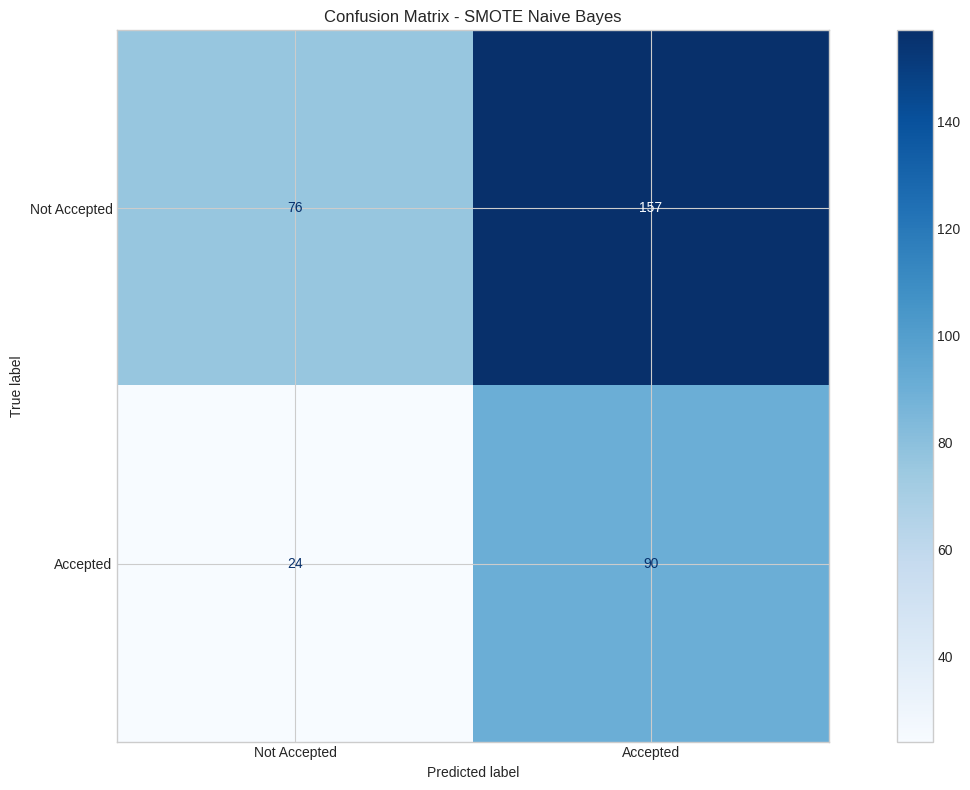

In [72]:
# Visualize confusion matrix for SMOTE (original features)
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_smote, display_labels=['Not Accepted', 'Accepted'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - SMOTE Naive Bayes')
plt.tight_layout()
plt.show()
# ANALYSIS: Compare with the original confusion matrix to see
# how prediction errors change with SMOTE oversampling

<Figure size 800x600 with 0 Axes>

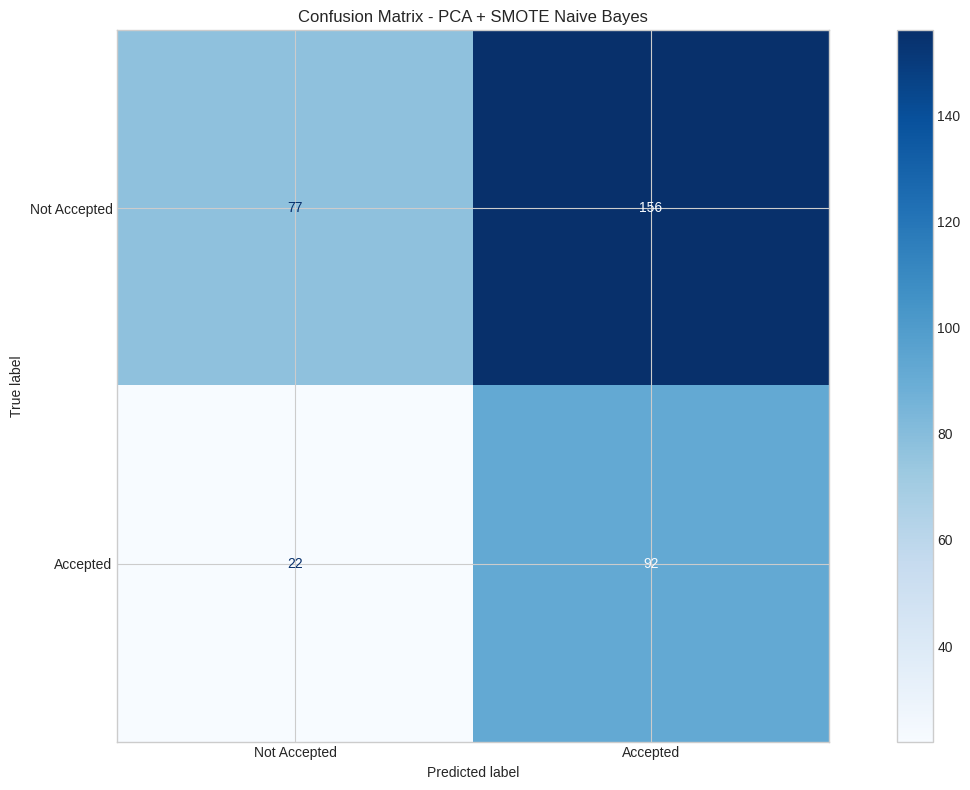

In [73]:
# Visualize confusion matrix for PCA + SMOTE
cm_pca_smote = confusion_matrix(y_test, y_pred_pca_smote)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca_smote, display_labels=['Not Accepted', 'Accepted'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - PCA + SMOTE Naive Bayes')
plt.tight_layout()
plt.show()

In [74]:
# Compare classification reports
print("\nSMOTE Classification Report:")
print(classification_report(y_test, y_pred_smote))

print("\nPCA + SMOTE Classification Report:")
print(classification_report(y_test, y_pred_pca_smote))


SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.33      0.46       233
           1       0.36      0.79      0.50       114

    accuracy                           0.48       347
   macro avg       0.56      0.56      0.48       347
weighted avg       0.63      0.48      0.47       347


PCA + SMOTE Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.33      0.46       233
           1       0.37      0.81      0.51       114

    accuracy                           0.49       347
   macro avg       0.57      0.57      0.49       347
weighted avg       0.64      0.49      0.48       347



## 7.3 Random Undersampling

In [75]:
print("\n7.3 Random Undersampling")
# ANALYSIS: Random undersampling reduces the majority class by randomly
# removing samples until classes are balanced
# This may discard useful information but helps with severe imbalance


7.3 Random Undersampling


In [76]:
# Apply random undersampling to majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [77]:
print(f"Original training set shape: {X_train.shape}, Class distribution: {np.bincount(y_train)}")
print(f"Undersampled training set shape: {X_train_rus.shape}, Class distribution: {np.bincount(y_train_rus)}")
# ANALYSIS: Undersampling creates a balanced dataset by removing majority samples
# The total dataset size is reduced to twice the size of the original minority class

Original training set shape: (1385, 37), Class distribution: [932 453]
Undersampled training set shape: (906, 37), Class distribution: [453 453]


In [78]:
# Apply random undersampling to PCA features
X_train_pca_rus, y_train_pca_rus = rus.fit_resample(X_train_pca, y_train)
print(f"PCA+Undersampled training set shape: {X_train_pca_rus.shape}, Class distribution: {np.bincount(y_train_pca_rus)}")


PCA+Undersampled training set shape: (906, 22), Class distribution: [453 453]


In [79]:
# Train model with undersampled original features
best_model_rus = GaussianNB()
best_model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = best_model_rus.predict(X_test)
f1_rus = f1_score(y_test, y_pred_rus)

In [80]:
# Train model with undersampled PCA features
best_model_pca_rus = GaussianNB()
best_model_pca_rus.fit(X_train_pca_rus, y_train_pca_rus)
y_pred_pca_rus = best_model_pca_rus.predict(X_test_pca)
f1_pca_rus = f1_score(y_test, y_pred_pca_rus)

In [81]:
print(f"Undersampled Naive Bayes - F1 Score: {f1_rus:.4f}")
print(f"PCA + Undersampled Naive Bayes - F1 Score: {f1_pca_rus:.4f}")
print(f"Original Naive Bayes - F1 Score: {f1:.4f}")
print(f"Improvement with Undersampling: {(f1_rus - f1) * 100:.2f}%")
print(f"Improvement with PCA + Undersampling: {(f1_pca_rus - f1) * 100:.2f}%")

Undersampled Naive Bayes - F1 Score: 0.5054
PCA + Undersampled Naive Bayes - F1 Score: 0.5014
Original Naive Bayes - F1 Score: 0.1460
Improvement with Undersampling: 35.94%
Improvement with PCA + Undersampling: 35.54%


In [82]:
# Compare classification reports
print("\nUndersampling Classification Report:")
print(classification_report(y_test, y_pred_rus))

print("\nPCA + Undersampling Classification Report:")
print(classification_report(y_test, y_pred_pca_rus))


Undersampling Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.31      0.44       233
           1       0.37      0.82      0.51       114

    accuracy                           0.48       347
   macro avg       0.57      0.56      0.47       347
weighted avg       0.64      0.48      0.46       347


PCA + Undersampling Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.31      0.44       233
           1       0.36      0.81      0.50       114

    accuracy                           0.47       347
   macro avg       0.56      0.56      0.47       347
weighted avg       0.63      0.47      0.46       347



# 8. Threshold Optimization

In [83]:
print("\n8. Decision Threshold Optimization")
print("-------------------------------")
# ANALYSIS: The default threshold of 0.5 may not be optimal for imbalanced data
# By adjusting this threshold, we can find better trade-offs between precision and recall


8. Decision Threshold Optimization
-------------------------------


In [84]:
# Calculate precision-recall curve for original model
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

In [85]:
# Calculate precision-recall curve for PCA model
precision_pca, recall_pca, thresholds_pca = precision_recall_curve(y_test, y_proba_pca)

In [86]:
# Calculate F1 score for each threshold - original model
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)  # Add epsilon to avoid division by 0
optimal_idx = np.argmax(f1_scores)  # Index of maximum F1 score
optimal_threshold = thresholds[optimal_idx]  # Threshold at maximum F1

In [87]:
# Calculate F1 score for each threshold - PCA model
f1_scores_pca = 2 * (precision_pca[:-1] * recall_pca[:-1]) / (precision_pca[:-1] + recall_pca[:-1] + 1e-10)
optimal_idx_pca = np.argmax(f1_scores_pca)
optimal_threshold_pca = thresholds_pca[optimal_idx_pca]

In [88]:
# Apply optimal threshold - original model
y_pred_optimized = (y_proba >= optimal_threshold).astype(int)
f1_optimized = f1_score(y_test, y_pred_optimized)

In [89]:
# Apply optimal threshold - PCA model
y_pred_pca_optimized = (y_proba_pca >= optimal_threshold_pca).astype(int)
f1_pca_optimized = f1_score(y_test, y_pred_pca_optimized)

In [90]:
print(f"Original threshold (0.5) - F1 Score: {f1:.4f}")
print(f"Optimal threshold ({optimal_threshold:.4f}) - F1 Score: {f1_optimized:.4f}")
print(f"PCA + Optimal threshold ({optimal_threshold_pca:.4f}) - F1 Score: {f1_pca_optimized:.4f}")
print(f"Improvement with Optimal Threshold: {(f1_optimized - f1) * 100:.2f}%")
print(f"Improvement with PCA + Optimal Threshold: {(f1_pca_optimized - f1) * 100:.2f}%")

Original threshold (0.5) - F1 Score: 0.1460
Optimal threshold (0.0523) - F1 Score: 0.5185
PCA + Optimal threshold (0.1518) - F1 Score: 0.5228
Improvement with Optimal Threshold: 37.25%
Improvement with PCA + Optimal Threshold: 37.69%


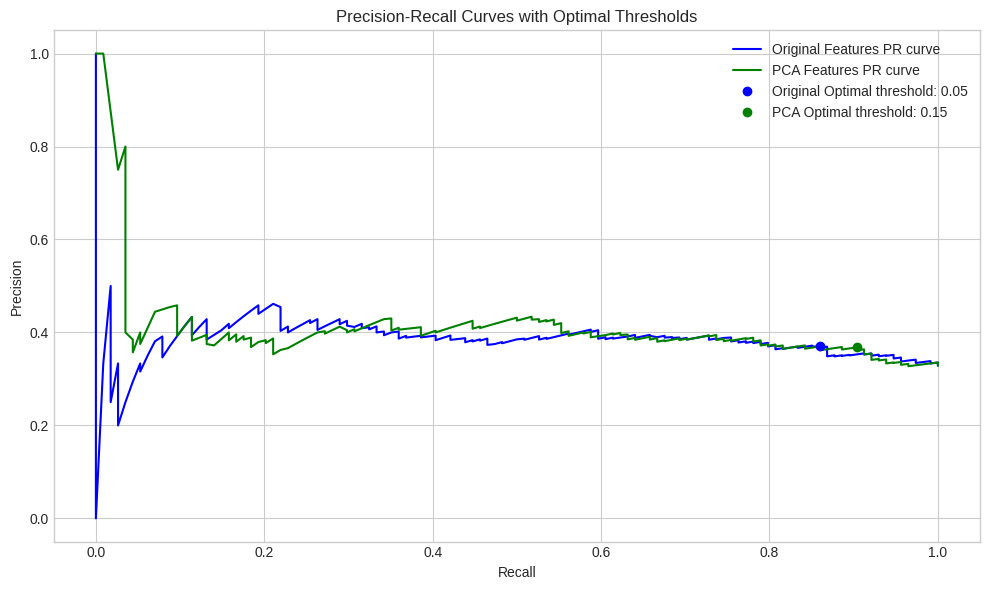

In [91]:
# Plot precision-recall curves with optimal thresholds
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', label='Original Features PR curve')
plt.plot(recall_pca, precision_pca, 'g-', label='PCA Features PR curve')
plt.plot(recall[optimal_idx], precision[optimal_idx], 'bo',
         label=f'Original Optimal threshold: {optimal_threshold:.2f}')
plt.plot(recall_pca[optimal_idx_pca], precision_pca[optimal_idx_pca], 'go',
         label=f'PCA Optimal threshold: {optimal_threshold_pca:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves with Optimal Thresholds')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
# ANALYSIS: The PR curve shows the trade-off between precision and recall
# The optimal threshold represents the best balance for our F1 optimization goal
# Points toward the upper-right corner represent better performance

# 9. Combining the Best Techniques

In [92]:
print("\n9. Combining Best Techniques")
print("-------------------------")
# ANALYSIS: It's often beneficial to combine multiple approaches
# Rather than selecting just one technique, we can layer them for maximum benefit



9. Combining Best Techniques
-------------------------


In [93]:
# Based on previous experiments, combine the best techniques
best_techniques = []
best_scores = {}

In [94]:
# Original model as baseline
best_scores['Original'] = f1
best_scores['PCA'] = f1_pca

In [95]:
# Best Naive Bayes variant (original features)
best_variant_name = best_variant[0]
best_variant_model = nb_variants[best_variant_name]
best_variant_model.fit(X_train, y_train)
y_pred_variant = best_variant_model.predict(X_test)
best_scores[f'Best Variant ({best_variant_name})'] = f1_score(y_test, y_pred_variant)
# ANALYSIS: Testing if alternative NB variant alone improves performance

In [96]:
# Best Naive Bayes variant with PCA
# Note: Some variants might not work with PCA if they require non-negative features
try:
    best_variant_model.fit(X_train_pca, y_train)
    y_pred_variant_pca = best_variant_model.predict(X_test_pca)
    f1_variant_pca = f1_score(y_test, y_pred_variant_pca)
    best_scores[f'PCA + {best_variant_name}'] = f1_variant_pca
except Exception as e:
    print(f"Warning: Could not apply {best_variant_name} to PCA features: {str(e)}")

In [97]:
# Individual techniques
best_scores['SMOTE'] = f1_smote
best_scores['PCA + SMOTE'] = f1_pca_smote
best_scores['Undersampling'] = f1_rus
best_scores['PCA + Undersampling'] = f1_pca_rus
best_scores['Threshold Optimization'] = f1_optimized
best_scores['PCA + Threshold Optimization'] = f1_pca_optimized

In [98]:
# Combined techniques - SMOTE with optimal threshold
best_model_smote = GaussianNB()
best_model_smote.fit(X_train_smote, y_train_smote)
y_proba_smote = best_model_smote.predict_proba(X_test)[:, 1]
y_pred_smote_optimized = (y_proba_smote >= optimal_threshold).astype(int)
f1_smote_optimized = f1_score(y_test, y_pred_smote_optimized)
best_scores['SMOTE + Optimal Threshold'] = f1_smote_optimized
print(f"SMOTE + Optimal Threshold - F1 Score: {f1_smote_optimized:.4f}")

SMOTE + Optimal Threshold - F1 Score: 0.5147


In [99]:
# Combined techniques - PCA + SMOTE with optimal threshold
best_model_pca_smote = GaussianNB()
best_model_pca_smote.fit(X_train_pca_smote, y_train_pca_smote)
y_proba_pca_smote = best_model_pca_smote.predict_proba(X_test_pca)[:, 1]
y_pred_pca_smote_optimized = (y_proba_pca_smote >= optimal_threshold_pca).astype(int)
f1_pca_smote_optimized = f1_score(y_test, y_pred_pca_smote_optimized)
best_scores['PCA + SMOTE + Optimal Threshold'] = f1_pca_smote_optimized
print(f"PCA + SMOTE + Optimal Threshold - F1 Score: {f1_pca_smote_optimized:.4f}")

PCA + SMOTE + Optimal Threshold - F1 Score: 0.4988


In [100]:
# Combined techniques - Undersampling with optimal threshold
best_model_rus = GaussianNB()
best_model_rus.fit(X_train_rus, y_train_rus)
y_proba_rus = best_model_rus.predict_proba(X_test)[:, 1]
y_pred_rus_optimized = (y_proba_rus >= optimal_threshold).astype(int)
f1_rus_optimized = f1_score(y_test, y_pred_rus_optimized)
best_scores['Undersampling + Optimal Threshold'] = f1_rus_optimized
print(f"Undersampling + Optimal Threshold - F1 Score: {f1_rus_optimized:.4f}")

Undersampling + Optimal Threshold - F1 Score: 0.5025


In [101]:
# Combined techniques - PCA + Undersampling with optimal threshold
best_model_pca_rus = GaussianNB()
best_model_pca_rus.fit(X_train_pca_rus, y_train_pca_rus)
y_proba_pca_rus = best_model_pca_rus.predict_proba(X_test_pca)[:, 1]
y_pred_pca_rus_optimized = (y_proba_pca_rus >= optimal_threshold_pca).astype(int)
f1_pca_rus_optimized = f1_score(y_test, y_pred_pca_rus_optimized)
best_scores['PCA + Undersampling + Optimal Threshold'] = f1_pca_rus_optimized
print(f"PCA + Undersampling + Optimal Threshold - F1 Score: {f1_pca_rus_optimized:.4f}")

PCA + Undersampling + Optimal Threshold - F1 Score: 0.4965


In [102]:
# Find the overall best combination
best_overall = max(best_scores.items(), key=lambda x: x[1])
print(f"\nBest overall technique: {best_overall[0]} with F1 Score: {best_overall[1]:.4f}")
print(f"Improvement over original: {(best_overall[1] - f1) * 100:.2f}%")


Best overall technique: PCA + Threshold Optimization with F1 Score: 0.5228
Improvement over original: 37.69%


<ipython-input-103-2e4d1e39aeba>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_scores, y=sorted_techniques, palette=colors)


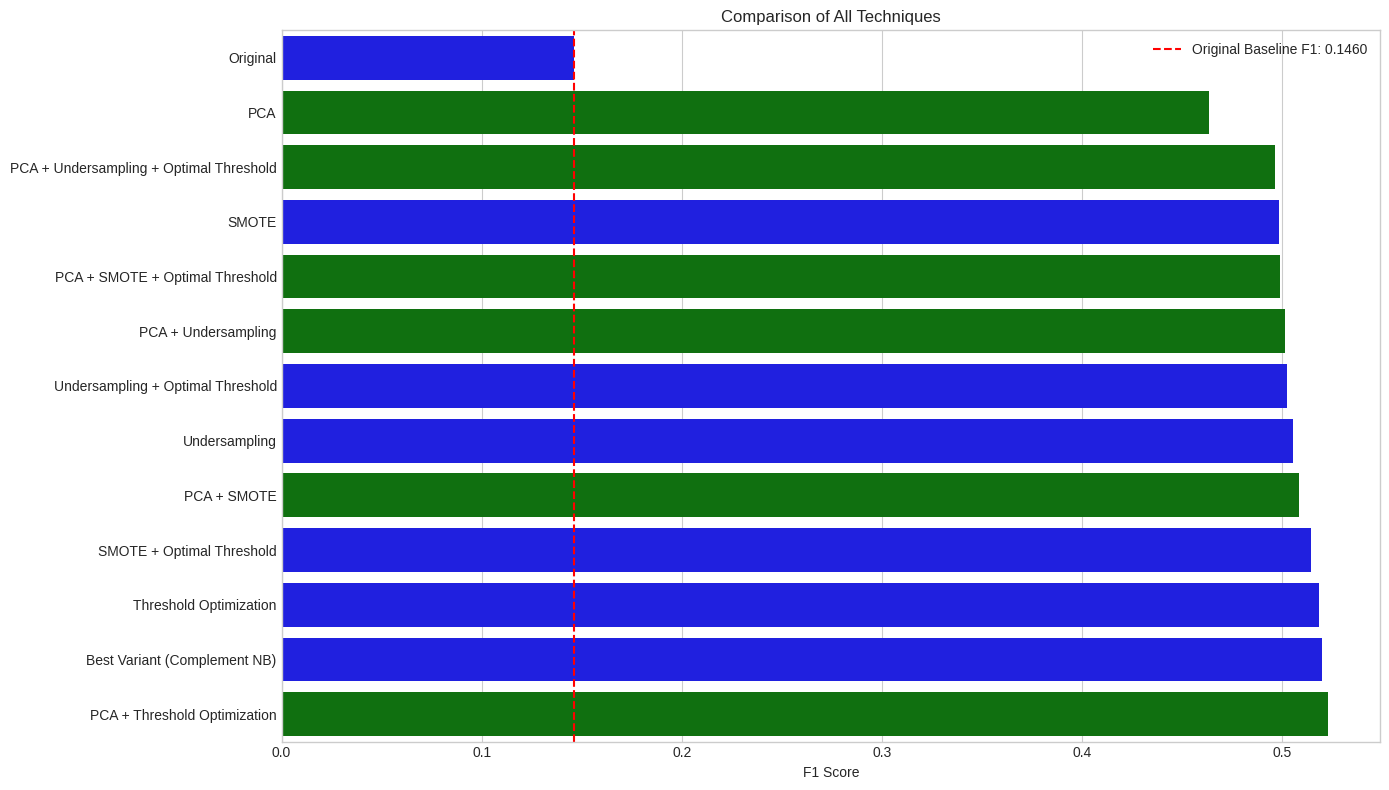

In [103]:
# Visualize the results
plt.figure(figsize=(14, 8))
techniques = list(best_scores.keys())
scores = list(best_scores.values())
# Sort by score
sorted_indices = np.argsort(scores)
sorted_techniques = [techniques[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]
colors = ['blue' if 'PCA' not in tech else 'green' for tech in sorted_techniques]
sns.barplot(x=sorted_scores, y=sorted_techniques, palette=colors)
plt.axvline(x=f1, color='red', linestyle='--', label=f'Original Baseline F1: {f1:.4f}')
plt.xlabel('F1 Score')
plt.title('Comparison of All Techniques')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Final Model and Performance

In [104]:
print("\n10. Final Model and Performance")
print("-----------------------------")


10. Final Model and Performance
-----------------------------


In [105]:
# Identify best approach based on previous experiments
best_approach = best_overall[0]
print(f"Best approach: {best_approach}")

Best approach: PCA + Threshold Optimization


In [106]:
# Define final model based on best approach
final_model = None
final_y_pred = None
model_description = []

In [107]:
# Set up the final model based on the best approach
if 'PCA' in best_approach:
    model_description.append("PCA")

if 'SMOTE' in best_approach:
    model_description.append("SMOTE")

if 'Undersampling' in best_approach:
    model_description.append("Undersampling")

if 'Optimal Threshold' in best_approach:
    model_description.append("Threshold Optimization")

if best_variant_name in best_approach:
    model_description.append(best_variant_name)

In [108]:
# ANALYSIS: This section implements the best approach identified in our experiments
# We're creating a new model instance with the optimal configuration

# Build the pipeline based on identified components
if 'PCA' in best_approach and 'SMOTE' in best_approach and 'Optimal Threshold' in best_approach:
    print("Implementing PCA + SMOTE + Optimal Threshold approach")
    final_model = GaussianNB()
    final_model.fit(X_train_pca_smote, y_train_pca_smote)
    y_proba_final = final_model.predict_proba(X_test_pca)[:, 1]
    final_y_pred = (y_proba_final >= optimal_threshold_pca).astype(int)
    final_threshold = optimal_threshold_pca
    uses_pca = True
    uses_threshold = True

elif 'PCA' in best_approach and 'Undersampling' in best_approach and 'Optimal Threshold' in best_approach:
    print("Implementing PCA + Undersampling + Optimal Threshold approach")
    final_model = GaussianNB()
    final_model.fit(X_train_pca_rus, y_train_pca_rus)
    y_proba_final = final_model.predict_proba(X_test_pca)[:, 1]
    final_y_pred = (y_proba_final >= optimal_threshold_pca).astype(int)
    final_threshold = optimal_threshold_pca
    uses_pca = True
    uses_threshold = True

elif 'PCA' in best_approach and 'SMOTE' in best_approach:
    print("Implementing PCA + SMOTE approach")
    final_model = GaussianNB()
    final_model.fit(X_train_pca_smote, y_train_pca_smote)
    final_y_pred = final_model.predict(X_test_pca)
    uses_pca = True
    uses_threshold = False

elif 'PCA' in best_approach and 'Undersampling' in best_approach:
    print("Implementing PCA + Undersampling approach")
    final_model = GaussianNB()
    final_model.fit(X_train_pca_rus, y_train_pca_rus)
    final_y_pred = final_model.predict(X_test_pca)
    uses_pca = True
    uses_threshold = False

elif 'PCA' in best_approach and 'Optimal Threshold' in best_approach:
    print("Implementing PCA + Optimal Threshold approach")
    final_model = GaussianNB()
    final_model.fit(X_train_pca, y_train)
    y_proba_final = final_model.predict_proba(X_test_pca)[:, 1]
    final_y_pred = (y_proba_final >= optimal_threshold_pca).astype(int)
    final_threshold = optimal_threshold_pca
    uses_pca = True
    uses_threshold = True

elif 'PCA' in best_approach:
    print("Implementing PCA approach")
    final_model = GaussianNB()
    final_model.fit(X_train_pca, y_train)
    final_y_pred = final_model.predict(X_test_pca)
    uses_pca = True
    uses_threshold = False

elif 'SMOTE' in best_approach and 'Optimal Threshold' in best_approach:
    print("Implementing SMOTE + Optimal Threshold approach")
    final_model = GaussianNB()
    final_model.fit(X_train_smote, y_train_smote)
    y_proba_final = final_model.predict_proba(X_test)[:, 1]
    final_y_pred = (y_proba_final >= optimal_threshold).astype(int)
    final_threshold = optimal_threshold
    uses_pca = False
    uses_threshold = True

elif 'Undersampling' in best_approach and 'Optimal Threshold' in best_approach:
    print("Implementing Undersampling + Optimal Threshold approach")
    final_model = GaussianNB()
    final_model.fit(X_train_rus, y_train_rus)
    y_proba_final = final_model.predict_proba(X_test)[:, 1]
    final_y_pred = (y_proba_final >= optimal_threshold).astype(int)
    final_threshold = optimal_threshold
    uses_pca = False
    uses_threshold = True

elif 'SMOTE' in best_approach:
    print("Implementing SMOTE approach")
    final_model = GaussianNB()
    final_model.fit(X_train_smote, y_train_smote)
    final_y_pred = final_model.predict(X_test)
    uses_pca = False
    uses_threshold = False

elif 'Undersampling' in best_approach:
    print("Implementing Undersampling approach")
    final_model = GaussianNB()
    final_model.fit(X_train_rus, y_train_rus)
    final_y_pred = final_model.predict(X_test)
    uses_pca = False
    uses_threshold = False

elif 'Optimal Threshold' in best_approach:
    print("Implementing Optimal Threshold approach")
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)
    y_proba_final = final_model.predict_proba(X_test)[:, 1]
    final_y_pred = (y_proba_final >= optimal_threshold).astype(int)
    final_threshold = optimal_threshold
    uses_pca = False
    uses_threshold = True

else:
    print("Implementing baseline GaussianNB approach")
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)
    final_y_pred = final_model.predict(X_test)
    uses_pca = False
    uses_threshold = False
# ANALYSIS: This code handles all possible combinations of techniques
# The final model configuration depends on which approach performed best

Implementing PCA approach


In [109]:
# Evaluate final model performance
final_accuracy = accuracy_score(y_test, final_y_pred)
final_precision = precision_score(y_test, final_y_pred)
final_recall = recall_score(y_test, final_y_pred)
final_f1 = f1_score(y_test, final_y_pred)

In [110]:
print("\nFinal Model Performance:")
print(f"Approach: {' + '.join(model_description)}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"Improvement over original: {(final_f1 - f1) * 100:.2f}%")
# ANALYSIS: These metrics represent the final tuned model performance
# They will be used for comparison with the original model


Final Model Performance:
Approach: PCA
Accuracy: 0.6196
Precision: 0.4318
Recall: 0.5000
F1 Score: 0.4634
Improvement over original: 31.74%


In [111]:
# Save final model for deployment
try:
    # Save the trained model
    joblib.dump(final_model, 'final_model_tech_moms.pkl')
    print("\nFinal model saved successfully as 'final_model_tech_moms.pkl'")

    # Save feature columns for deployment
    joblib.dump(feature_columns, 'final_model_feature_columns.pkl')
    print("Feature columns saved successfully as 'final_model_feature_columns.pkl'")

    # Save model metadata
    model_metadata = {
        'approach': best_approach,
        'f1_score': final_f1,
        'accuracy': final_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'uses_pca': uses_pca,
        'uses_threshold': uses_threshold
    }
    joblib.dump(model_metadata, 'final_model_metadata.pkl')
    print("Model metadata saved successfully as 'final_model_metadata.pkl'")

    # If PCA was used in the best model, save the PCA transformer
    if uses_pca:
        joblib.dump(pca, 'final_model_pca_transformer.pkl')
        joblib.dump(scaler, 'final_model_scaler.pkl')
        print("PCA transformer and scaler saved successfully")

    # Save optimal threshold if it was used
    if uses_threshold:
        joblib.dump(final_threshold, 'final_model_optimal_threshold.pkl')
        print("Optimal threshold saved successfully")

    print("\nAll model components saved for deployment!")
except Exception as e:
    print(f"Error saving model components: {str(e)}")

print("\nModel Tuning Complete!")


Final model saved successfully as 'final_model_tech_moms.pkl'
Feature columns saved successfully as 'final_model_feature_columns.pkl'
Model metadata saved successfully as 'final_model_metadata.pkl'
PCA transformer and scaler saved successfully

All model components saved for deployment!

Model Tuning Complete!


# 11. Next Steps for Production

In [112]:
print("\n11. Next Steps")
print("------------")

print("\nThis notebook has focused on tuning the Naive Bayes model identified in the benchmarking phase.")
print("The next steps in the machine learning pipeline are:")

print("\n1. Production Model and Insights (05_Production_Model_and_Insights.ipynb):")
print("   • Package the final model for deployment")
print("   • Extract actionable insights from the model")
print("   • Create visualization tools for program administrators")
print("   • Develop a system for making predictions on new applicants")

print("\nThe tuning results from this notebook will inform the production deployment,")
print("focusing on the following key insights:")
print(f"   • Best model approach: {best_approach}")
print(f"   • Key performance metrics: F1 Score = {final_f1:.4f}")
print(f"   • Improvement over baseline: {(final_f1 - f1) * 100:.2f}%")


11. Next Steps
------------

This notebook has focused on tuning the Naive Bayes model identified in the benchmarking phase.
The next steps in the machine learning pipeline are:

1. Production Model and Insights (05_Production_Model_and_Insights.ipynb):
   • Package the final model for deployment
   • Extract actionable insights from the model
   • Create visualization tools for program administrators
   • Develop a system for making predictions on new applicants

The tuning results from this notebook will inform the production deployment,
focusing on the following key insights:
   • Best model approach: PCA + Threshold Optimization
   • Key performance metrics: F1 Score = 0.4634
   • Improvement over baseline: 31.74%
